# Nueral Style transfer with pre-trained VGG19 model


Neural style transfer is a sophisticated technique in computer vision that leverages deep learning networks to blend the content of one image or video with the artistic style of another, often inspired by renowned artworks. The underlying principle revolves around the ability to disentangle representations of style and content within a Convolutional Neural Network (CNN). This separation is initially acquired during the network's training for tasks like image recognition. Through this process, neural style transfer allows for the creation of visually compelling compositions, merging the content of one input with the distinctive aesthetic characteristics of another, resulting in a unique and captivating visual synthesis.


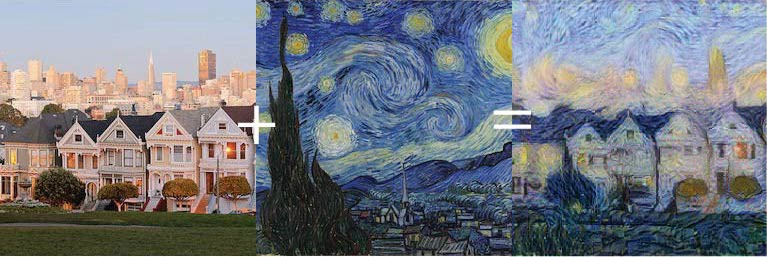

As seen, the generated image is having the content of the content image and style of the style image.

Note - The choice of the VGG model over other deep convolutional neural networks (CNNs) is multifaceted. Firstly, the authors of the original paper recommended the use of the VGG architecture, suggesting that it could yield superior results. Secondly, after conducting further research online, it became evident that the complexity of architectures in other very deep CNNs, such as ResNet, might not necessarily translate to better performance in certain applications. In some cases, the feature maps from VGG16 or VGG19 were found to provide more optimal results compared to their counterparts in more intricate CNNs. Therefore, the preference for the VGG model is rooted in both the recommendations from the original paper and the observed effectiveness of its feature maps, especially when compared to the feature maps of other highly complex CNNs like ResNet.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing necessary libraries**

In [2]:
# !pip install tensorflow
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

C:\Users\dadha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
content_path='content2.jpg'
style_path = 'style3.jpg'

**Define function to load images and return numpy array**

In [4]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                               #batch of single image 
    
    return im_array

**Define function to plot image**

In [5]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

**Plot Image**

In [6]:
content = load_file(content_path)
style = load_file(style_path)

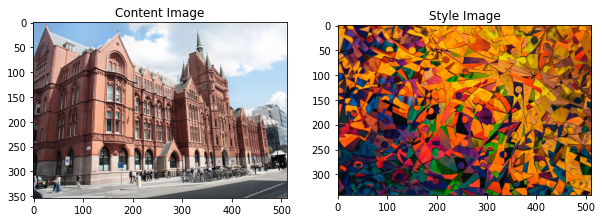

In [7]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

**Define function to process image for input to vgg19 model**

In [8]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

**Define function to deprocess image **

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [9]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [10]:
im=img_preprocess(content_path)

**Get necessary layers from vgg19 model**

In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get vgg19 model with pretrained weights**

In [12]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [13]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

80134624/80134624 [==============================] - 16s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

**Model architecture**

In [14]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


Loss Functions

Neural style transfer involves optimizing an image by minimizing two key loss functions: content loss and style loss. These functions are crucial in aligning the generated image with both the content image and the style image.

The content loss function focuses on minimizing the differences in activations between higher layers of the content image and the generated image. This ensures that the generated image captures the essential content features present in the content image.

On the other hand, the style loss function aims to minimize variations in the correlation of activations across all layers between the style image and the generated image. By doing so, the generated image adopts the artistic style of the style image.

Through a process of backpropagation, the base input image is transformed to strike a balance between content and style by iteratively minimizing these loss functions. This methodology creates an image that not only reflects the content of the content image but also embodies the stylistic elements of the style image.

**Define content loss**

Essentially content loss captures the root mean squared error between the activations produced by the generated image and the content image.

In [15]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

Style Loss:

Style loss is a metric used in the context of neural style transfer algorithms, where the goal is to generate an image that combines the content of one image with the artistic style of another. The process involves quantifying the stylistic features present in a reference or "style" image and transferring these features to a generated image. The style loss is calculated by comparing the correlation of feature maps between the generated image and the style image.

To compute style loss, a style matrix is created for both the generated and style images by using the Gram matrix, which captures the correlation between feature maps in a given convolutional layer. The style loss is then defined as the root mean square difference between the two style matrices. In essence, it measures the discrepancy in the correlation of features between the generated image and the style image.

In simpler terms, style loss quantifies how well the generated image mimics the artistic style of the reference image by examining the correlation of features at different layers. The use of the Gram matrix helps capture the stylistic essence of the images, allowing for a more nuanced comparison that goes beyond pixel-level differences.

In [30]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [17]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    

In [18]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

**Define function to compute total loss**

In [19]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

**Define function to calculate gradient**

In [20]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [21]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [22]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [23]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

# **Style Transfer Visualization**

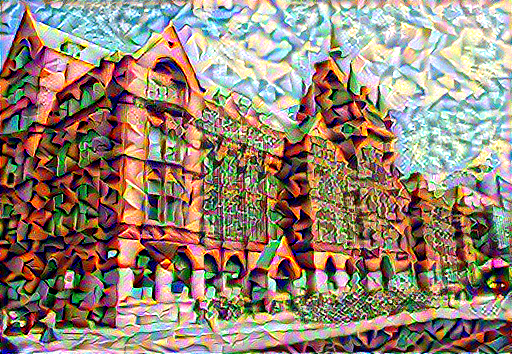

Epoch: 95
Total loss: 5.3293e+07, style loss: 4.6169e+07, content loss: 7.1232e+06, 


In [25]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=100)


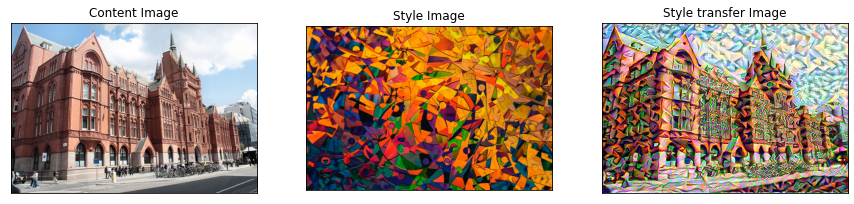

In [26]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()